# Análisis Exploratorio

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor

In [42]:
data = pd.read_csv('../data/data_globant.csv')
data = data.drop(columns=['Email', 'Year', 'Client', 'Project'])

In [3]:
data.head()

,Date,Name,Position,Seniority,Location,Studio,Client Tag,Project Tag,Team Name,Engagement,Email Leader,Month,Day
0,02Jan23,Natalia Ramírez,Software Developer,Jr,CO/ANT/MED,Engineering,GWI001,ATLINT,Breaking Badger,3.04,laura.leon@tec.globant.com,1,2
1,03Jan23,Natalia Ramírez,Software Developer,Jr,CO/ANT/MED,Engineering,GWI001,ATLINT,Breaking Badger,2.99,laura.leon@tec.globant.com,1,3
2,04Jan23,Natalia Ramírez,Software Developer,Jr,CO/ANT/MED,Engineering,GWI001,ATLINT,Breaking Badger,2.97,laura.leon@tec.globant.com,1,4
3,05Jan23,Natalia Ramírez,Software Developer,Jr,CO/ANT/MED,Engineering,GWI001,ATLINT,Breaking Badger,2.75,laura.leon@tec.globant.com,1,5
4,06Jan23,Natalia Ramírez,Software Developer,Jr,CO/ANT/MED,Engineering,GWI001,ATLINT,Breaking Badger,3.15,laura.leon@tec.globant.com,1,6


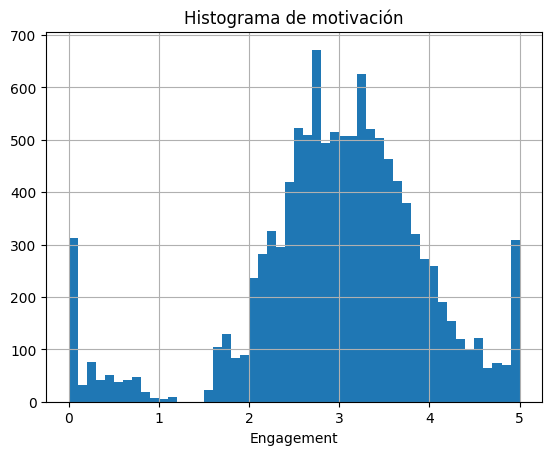

In [4]:
# Histograma de engagement
plt.hist(data['Engagement'], bins=50)
plt.title('Histograma de motivación')
plt.xlabel('Engagement')
plt.grid()

array([[<Axes: title={'center': 'Ana Aguayo'}>,
        <Axes: title={'center': 'Ana Gómez'}>,
        <Axes: title={'center': 'Ana Paredes'}>],
       [<Axes: title={'center': 'Carlos Villanueva'}>,
        <Axes: title={'center': 'Cristian Bravo'}>,
        <Axes: title={'center': 'Laura León'}>],
       [<Axes: title={'center': 'Lucía Arce'}>,
        <Axes: title={'center': 'Mariana Bravo'}>,
        <Axes: title={'center': 'Natalia Ramírez'}>],
       [<Axes: title={'center': 'Oscar Fernández'}>,
        <Axes: title={'center': 'Pedro Fuentes'}>,
        <Axes: title={'center': 'Valeria Díaz'}>]], dtype=object)

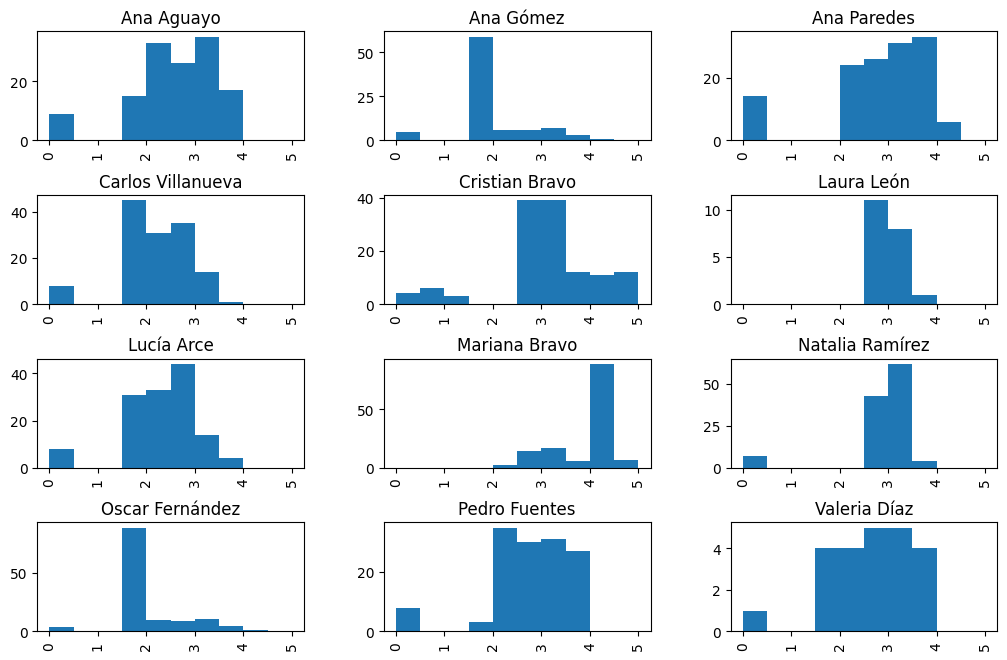

In [5]:
personas = data.head(1200)['Name'].unique()
data2 = data.iloc[[ind for ind, name in enumerate(data['Name']) if name in personas], :]
data2['Engagement'].hist(
    by=data2['Name'],
    figsize=(12, 8),
    range = (0,5)
)

In [ ]:
# Discretizacion de Engagement
engagement = data['Engagement'].copy()
for i in range(1, 51):
    engagement.loc[(data['Engagement'] >= (i-1)/10) & (data['Engagement'] < i/10)] = i
engagement[data['Engagement'] == 5] = 50
data['Engagement'] = engagement

In [ ]:
# Ordinal Encoding para Seniority
seniority_levels = ['Jr', 'Ssr', 'Sr Level 1', 'Sr Level 2', 'Sr Level 3']
mapeo = {categoria: i for i, categoria in enumerate(seniority_levels)}
data['Seniority'] = data['Seniority'].map(mapeo)

(array([312.,  32.,  75.,  41.,  51.,  38.,  42.,  48.,  18.,   7.,   6.,
          9.,   0.,   0.,   0.,  23., 105., 130.,  58., 116., 236., 282.,
        310., 286., 444., 523., 510., 638., 479., 563., 507., 507., 573.,
        519., 556., 463., 422., 355., 316., 301., 236., 214., 155., 119.,
        101.,  96.,  91.,  69., 384.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
        40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 <BarContainer object of 49 artists>)

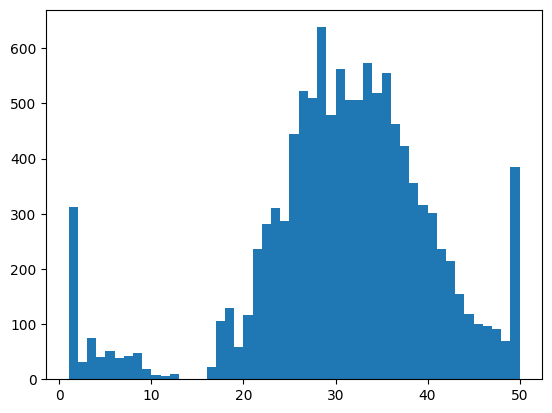

In [62]:
plt.hist(data['Engagement'], bins=49)

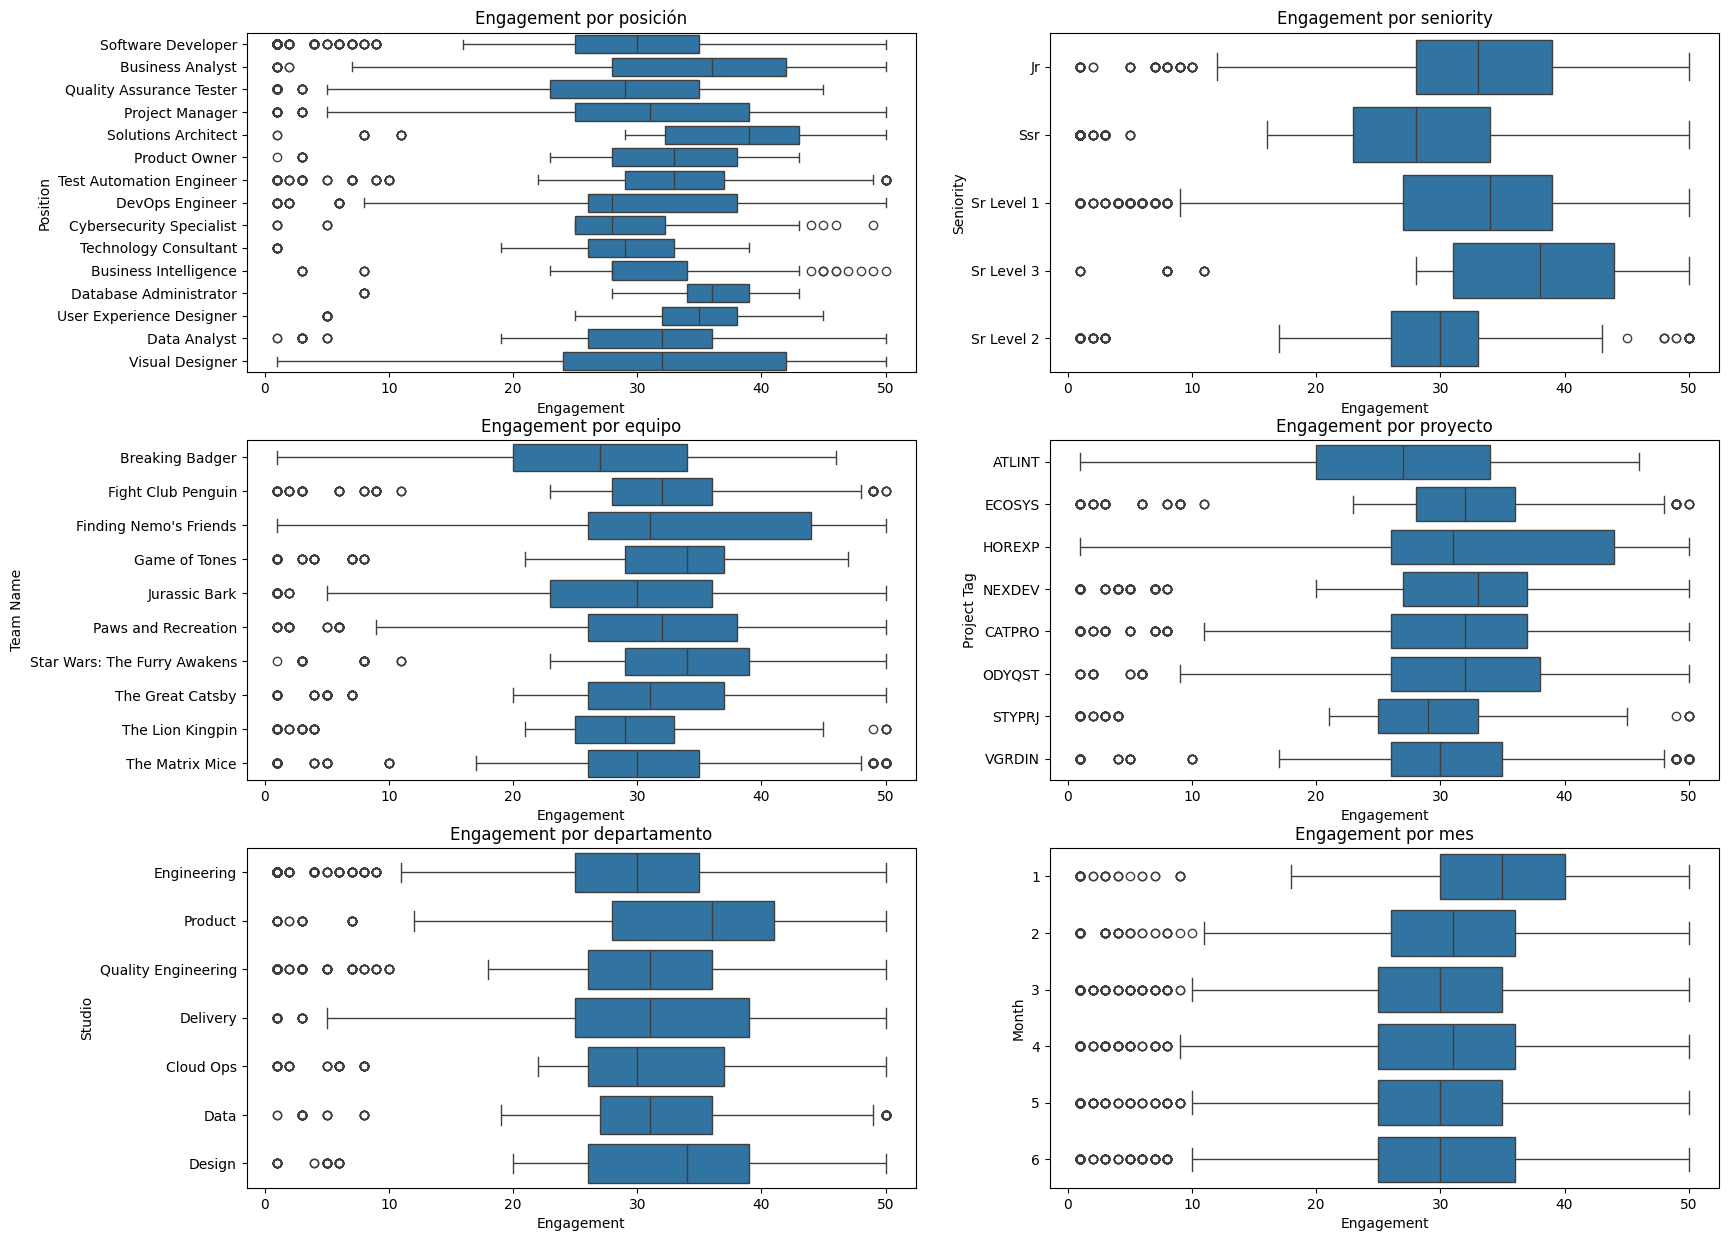

In [25]:
plt.figure(figsize=(19,15))

plt.subplot(3,2,1)
sns.boxplot(x='Engagement', y='Position', data=data)
plt.title("Engagement por posición")

plt.subplot(3,2,2)
sns.boxplot(x='Engagement', y='Seniority', data=data)
plt.title("Engagement por seniority")

plt.subplot(3,2,3)
sns.boxplot(y='Team Name', x='Engagement', data=data)
plt.title("Engagement por equipo")

plt.subplot(3,2,4)
sns.boxplot(y='Project Tag', x='Engagement', data=data)
plt.title("Engagement por proyecto")

plt.subplot(3,2,5)
sns.boxplot(y=data['Studio'], x=data['Engagement'])
plt.title("Engagement por departamento")

plt.subplot(3,2,6)
sns.boxplot(y=data['Month'].astype(str), x=data['Engagement'])
plt.title("Engagement por mes")

plt.show()

### Feature selection para engagement

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11366 entries, 0 to 11365
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          11366 non-null  object 
 1   Name          11366 non-null  object 
 2   Position      11366 non-null  object 
 3   Seniority     11366 non-null  int64  
 4   Location      11366 non-null  object 
 5   Studio        11366 non-null  object 
 6   Client Tag    11366 non-null  object 
 7   Project Tag   11366 non-null  object 
 8   Team Name     11366 non-null  object 
 9   Engagement    11366 non-null  float64
 10  Email Leader  10226 non-null  object 
 11  Month         11366 non-null  int64  
 12  Day           11366 non-null  int64  
dtypes: float64(1), int64(3), object(9)
memory usage: 1.1+ MB


In [54]:
for k in [5, 10, 15, 20]:
    selector = SelectKBest(score_func=f_regression, k=k)
    X = pd.get_dummies(data.drop(columns=['Engagement', 'Date']), dummy_na=True, drop_first=True)
    y = data['Engagement']

    selector.fit(X, y)
    selected_features_mask = selector.get_support()
    selected_feature_names = X.columns[selected_features_mask]

    print(f"\nBest {k} features:")
    print(selected_feature_names)


Best 5 features:
Index(['Month', 'Name_Alberto Cordero', 'Name_Jimena Morales',
       'Name_Oscar Aguirre', 'Location_MX/JALISCO/GDL'],
      dtype='object')

Best 10 features:
Index(['Month', 'Name_Alberto Cordero', 'Name_Carlos Silva',
       'Name_Gabriela Pérez', 'Name_Jimena Morales', 'Name_Oscar Aguirre',
       'Location_CO/ANT/MED', 'Location_MX/JALISCO/GDL', 'Studio_Product',
       'Client Tag_GWI001'],
      dtype='object')

Best 15 features:
Index(['Month', 'Name_Alberto Cordero', 'Name_Carlos Silva',
       'Name_Carolina Herrera', 'Name_Gabriela Pérez', 'Name_Jimena Morales',
       'Name_Oscar Aguirre', 'Name_Oscar Fernández',
       'Position_Software Developer', 'Position_Solutions Architect',
       'Location_CO/ANT/MED', 'Location_MX/JALISCO/GDL', 'Studio_Product',
       'Client Tag_GWI001', 'Team Name_Star Wars: The Furry Awakens'],
      dtype='object')

Best 20 features:
Index(['Month', 'Name_Alberto Cordero', 'Name_Ana Gómez', 'Name_Andrés Medina',
       'Nam

In [57]:
encoder = LabelEncoder()

X = data.drop(columns=['Engagement'])
for col in X.columns:
    if (col == 'Month') or (col == 'Day') or (col == 'Seniority'):
        continue
    X[col] = encoder.fit_transform(X[col])

cat_features = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10]
mi = mutual_info_regression(X, y, discrete_features=cat_features)

print("Order of importance of variables:")
print(X.columns[np.argsort(mi)[::-1]])

Order of importance of variables:
Index(['Name', 'Position', 'Email Leader', 'Team Name', 'Project Tag',
       'Seniority', 'Location', 'Studio', 'Client Tag', 'Month', 'Day',
       'Date'],
      dtype='object')


In [60]:
X = data.drop(columns=['Engagement'])
X.loc[X['Email Leader'].isna(), 'Email Leader'] = "No email leader"

model = CatBoostRegressor(verbose=0)
cat_features = X.columns[[0, 1, 2, 4, 5, 6, 7, 8, 9, 10]].values
model.fit(X, y, cat_features=cat_features)

print("Order of importance of variables:")
print(X.columns[np.argsort(model.get_feature_importance())[::-1]])

Order of importance of variables:
Index(['Name', 'Month', 'Day', 'Location', 'Studio', 'Position', 'Client Tag',
       'Email Leader', 'Date', 'Seniority', 'Team Name', 'Project Tag'],
      dtype='object')


### Timeline de engagement medio por persona

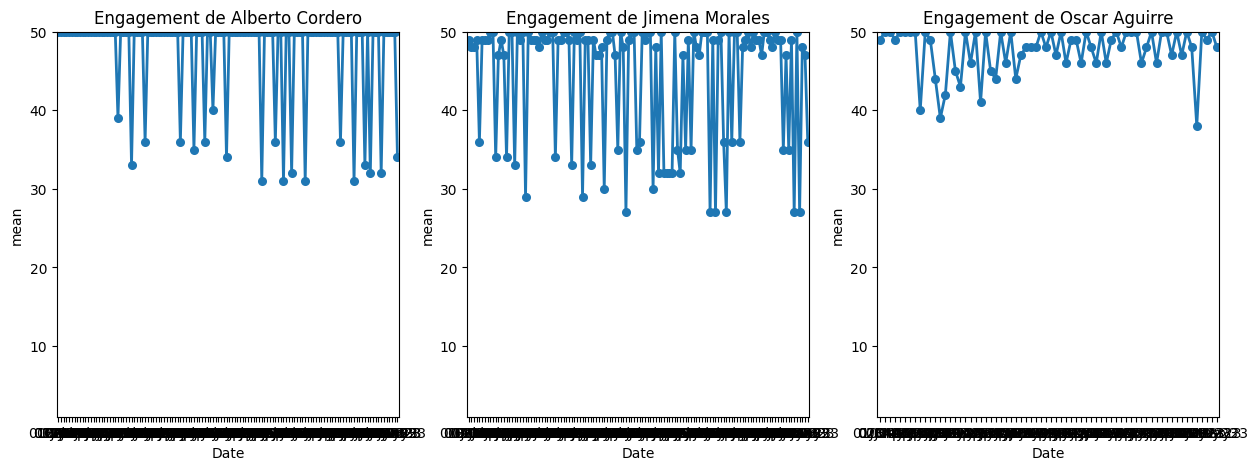

In [61]:
names = ['Alberto Cordero', 'Jimena Morales', 'Oscar Aguirre']
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    data2 = data.loc[data['Name'] == names[i], :].groupby('Date')['Engagement'].agg(['mean']).reset_index()
    sns.pointplot(x='Date', y='mean', data=data2, linewidth=2)
    plt.title(f'Engagement de {names[i]}')
    plt.ylim((1, 50))